# Voxel CSV --> Neural Cellular Automata

In [1]:
from tqdm.notebook import tqdm
import wandb
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from moviepy import ImageSequenceClip

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Voxel CSV to Torch Tensor

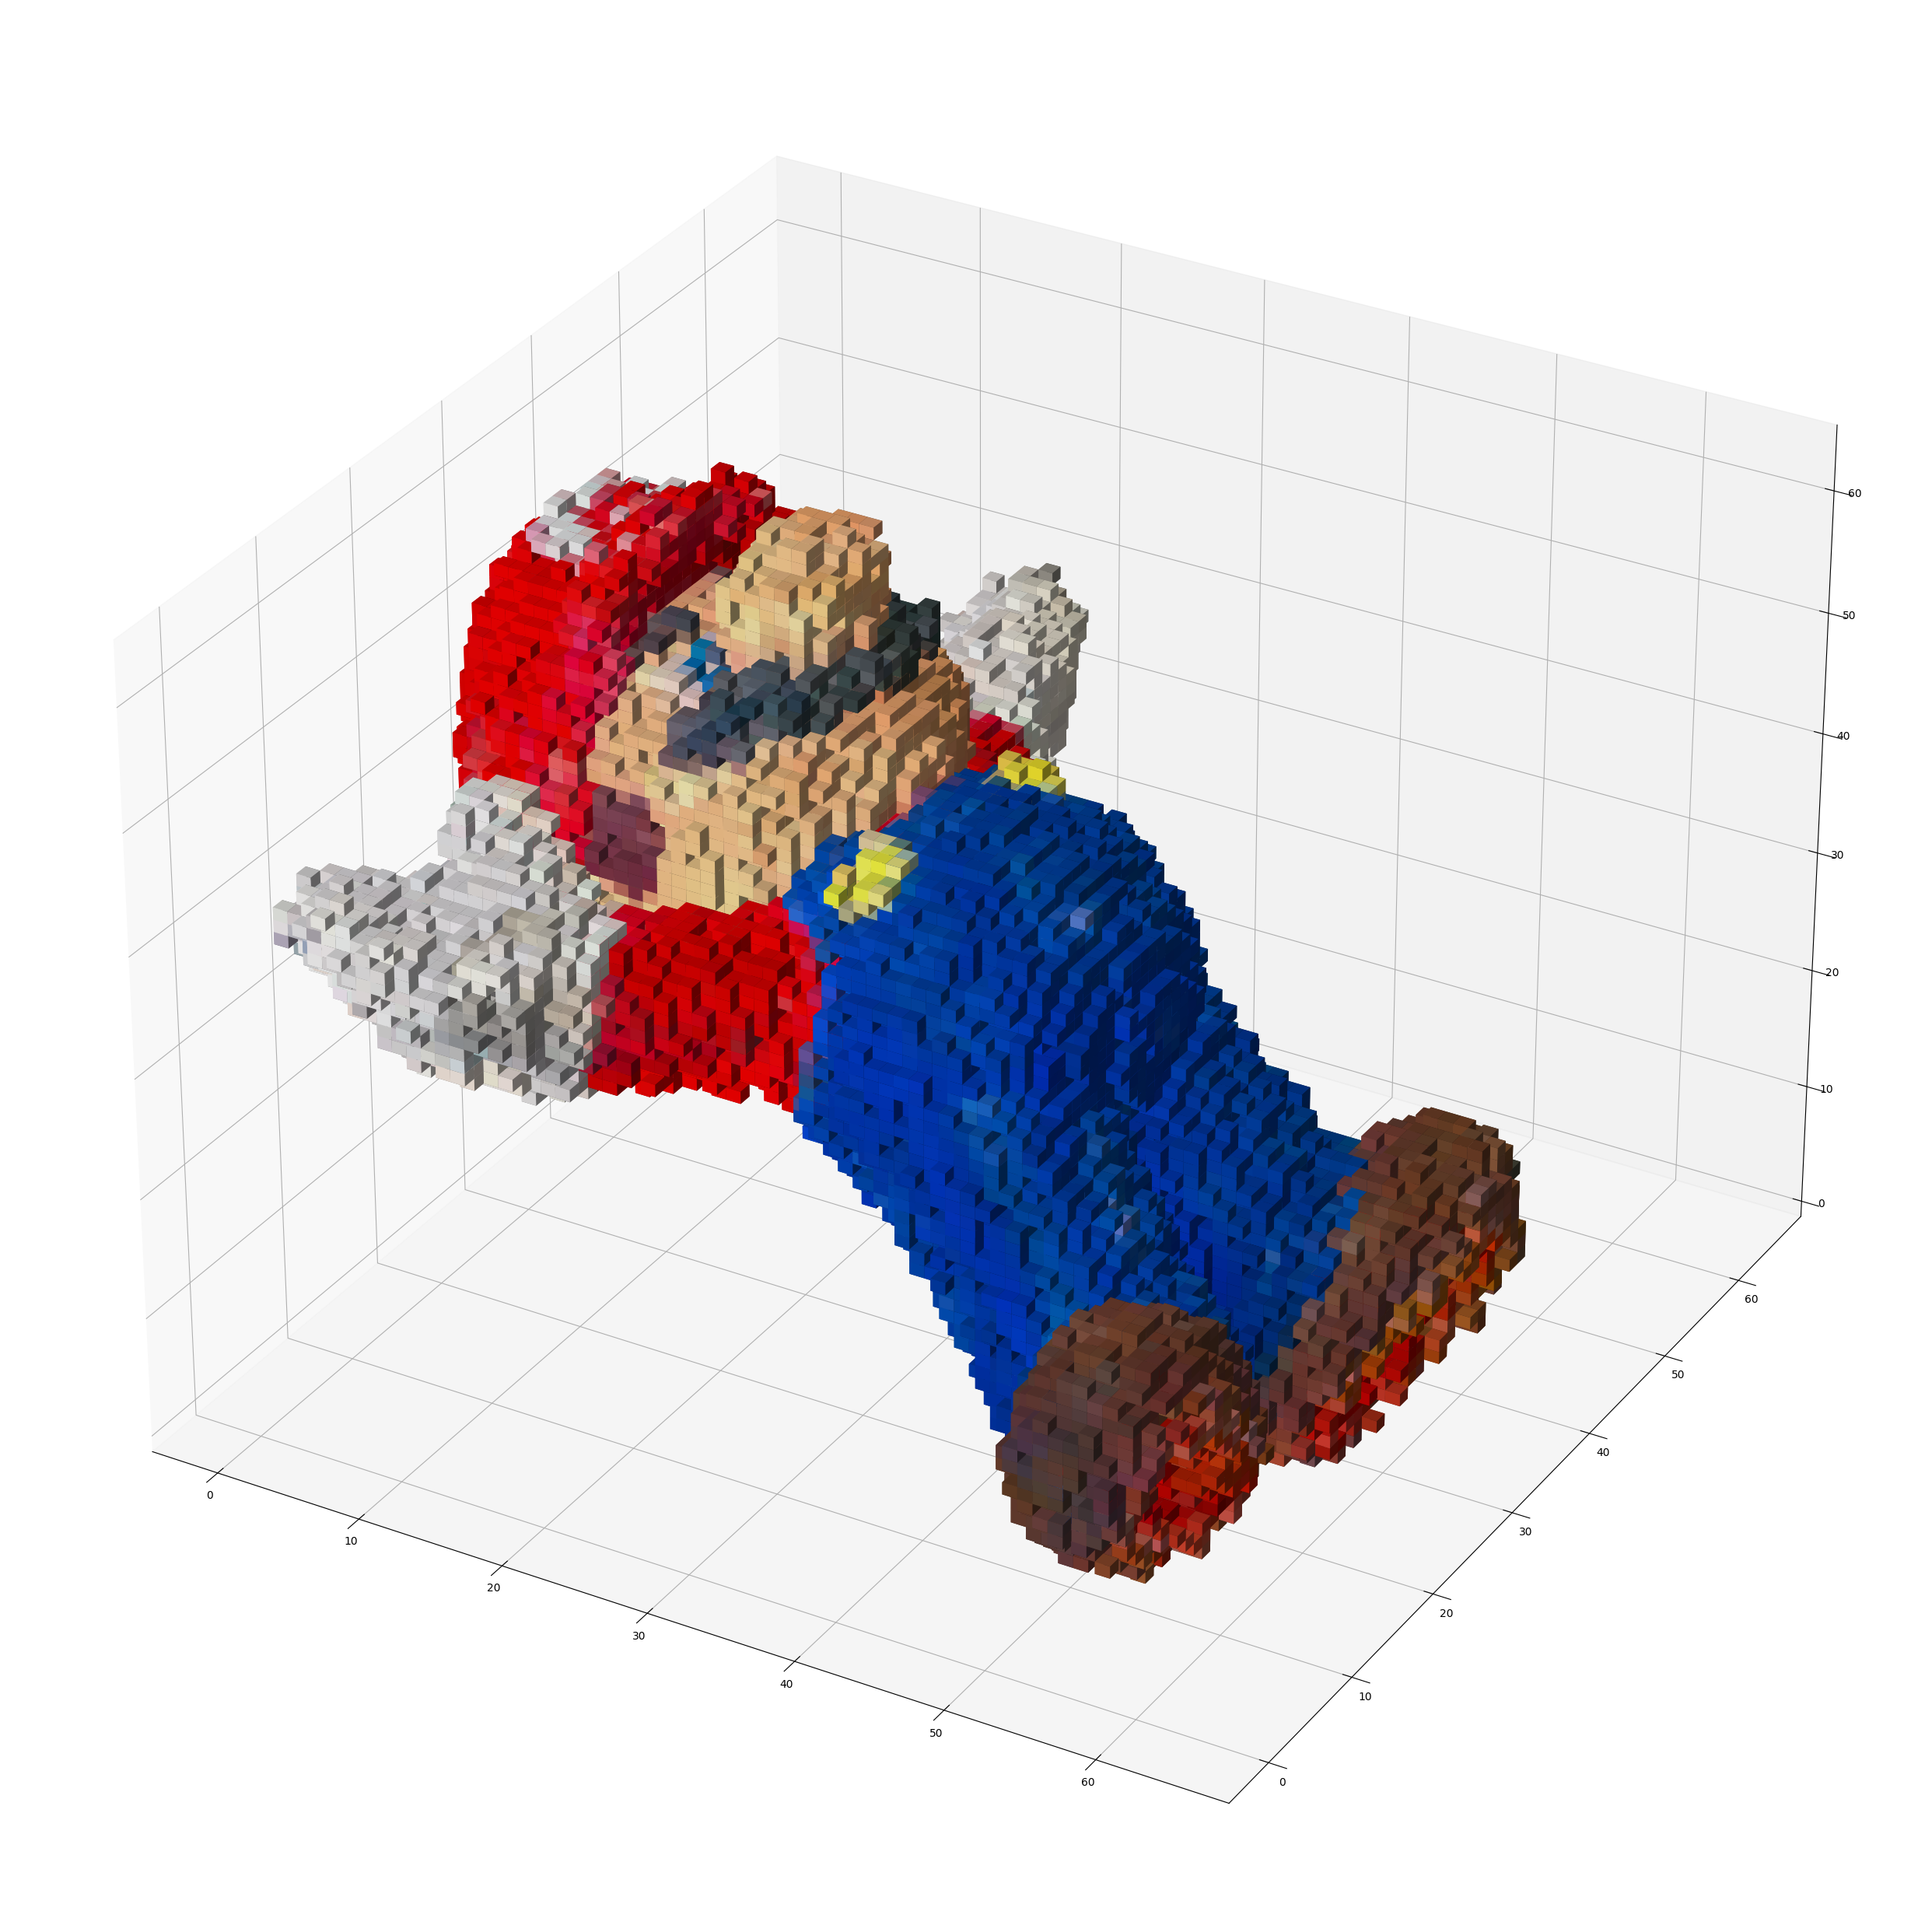

In [35]:
### FULL-RES VERSION (Use this if you want full-res)
###    => Only run either this cell or the next cell

img_data_path = "./data/npy_voxels/mario_vox_fixed.npy"

environment_size = 64
alive_thres = 0.1
vox_data = np.load(img_data_path)
in_vox_shape = vox_data[:, :3].max(axis=0) - vox_data[:, :3].min(axis=0) + 1  # find bounding box based on input data
left_padding = (environment_size - in_vox_shape) // 2

# vox_data = np.array(pd.read_csv(img_data_path, header=None))
rgba_vox = np.zeros((environment_size, environment_size, environment_size, 4))

for voxel in vox_data:
    pos = (voxel[:3] + left_padding).astype(int)
    if np.all((0 <= pos) & (pos < environment_size)):
        pos = tuple(pos)
        color = np.concatenate(((voxel[3:] / 255), np.ones(1)))
        rgba_vox[pos] = color

fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot(projection='3d')
ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
plt.show()

rgba_voxels = torch.tensor(rgba_vox, dtype=torch.float32).permute(3, 0, 1, 2).to(device)


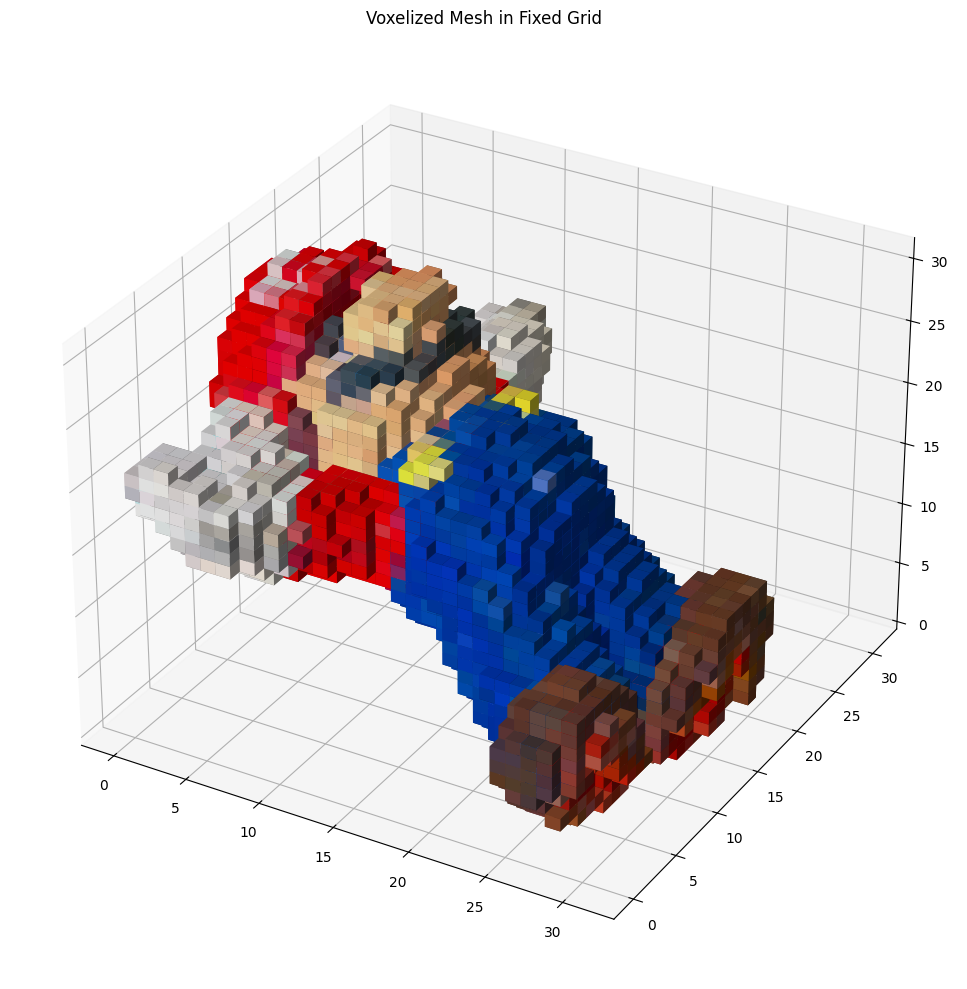

In [ ]:
### NORMALIZED VERSION (PREFERRED)
###    => Only run either this cell or the cell before

###   - Trying to downsample large meshes into small environments
img_data_path = "./data/npy_voxels/mario_vox_fixed.npy"

environment_size = 32
alive_thres = 0.1

vox_data = np.load(img_data_path)
coords = vox_data[:, :3]
min_coords = coords.min(axis=0)
max_coords = coords.max(axis=0)

# Normalize to [0, 1], then scale to [0, environment_size-1]
scaled_coords = (coords - min_coords) / (max_coords - min_coords + 1e-8)
voxel_coords = (scaled_coords * (environment_size - 1)).astype(int)  # shape: (N, 3)

rgba_vox = np.zeros((environment_size, environment_size, environment_size, 4), dtype=np.float32)

for i in range(len(voxel_coords)):
    x, y, z = voxel_coords[i]
    r, g, b = vox_data[i, 3:] / 255.0
    rgba_vox[x, y, z] = [r, g, b, 1.0] # 1.0 is for alpha

alive_thres = 0.1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
plt.title("Voxelized Mesh in Fixed Grid")
plt.tight_layout()
plt.show()

rgba_voxels = torch.tensor(rgba_vox, dtype=torch.float32).permute(3, 0, 1, 2).to(device)

### Model

In [23]:
def generate_seed(n_channels, env_dim):
    seed = torch.zeros((n_channels, env_dim, env_dim, env_dim), dtype=torch.float32)
    seed[3:, env_dim//2, env_dim//2, env_dim//2] = 1.
    return seed

class NCA(nn.Module):
    def __init__(self, n_channels, env_dim, learn_seed=True, seed_std=0.01, update_prob=0.5, alive_thres=0.1, overgrowth_to_undergrowth_penalty=1.0):
        super().__init__()

        self.update_prob = update_prob
        self.alive_thres = alive_thres
        self.overgrowth_to_undergrowth_penalty = overgrowth_to_undergrowth_penalty

        self.seed = generate_seed(n_channels, env_dim).to(device)
        if learn_seed:
            self.seed[4:, env_dim//2, env_dim//2, env_dim//2] = torch.randn(n_channels-4) * seed_std
            self.seed = nn.Parameter(self.seed)

        # Perception layer
        self.perceive = nn.Conv3d(n_channels, 3*n_channels, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm((3 * n_channels, env_dim, env_dim, env_dim))
        
        # Processing layers with residual connections
        self.process1 = nn.Conv3d(3*n_channels, 2*n_channels, kernel_size=1)
        self.process2 = nn.Conv3d(2*n_channels, n_channels, kernel_size=1)
    
    def forward(self, x, use_soft_living_mask=False):
        update_mask = (torch.rand(x[:, :1].shape, dtype=torch.float32).to(device) <= self.update_prob).float()
        
        y = self.perceive(x)
        y = self.norm1(y)
        y = F.relu(y)
        
        z = self.process1(y)
        z = F.relu(z)
        dx = self.process2(z)
        
        x = x + dx*update_mask
        
        if self.training:
            alpha = 0.8 
            soft_mask = F.sigmoid((F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) - self.alive_thres) * 50)
            hard_mask = (F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) > self.alive_thres).float()
            living_mask = alpha * soft_mask + (1-alpha) * hard_mask
        else:
            living_mask = (F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) > self.alive_thres).float()
            
        return x * living_mask
    
    def get_loss(self, x, target_vox):
        target = torch.tile(target_vox, (x.shape[0], 1, 1, 1, 1))
        x_rgba = x[:, :4]

        x_living_mask = (x_rgba[:, 3:4] > self.alive_thres).float()
        target_living_mask = (target[:, 3:4] > self.alive_thres).float()

        undergrowth_loss = F.mse_loss(x_rgba * target_living_mask, target * target_living_mask) 
        overgrowth_loss = self.overgrowth_to_undergrowth_penalty * F.mse_loss(x_rgba * (1.-target_living_mask) * x_living_mask, torch.zeros(target.shape).to(device))
        loss = undergrowth_loss + overgrowth_loss
        return loss, undergrowth_loss, overgrowth_loss


In [24]:
model_name = "mario_epochs_1000"

batch_size = 8
input_channels = 16
learn_seed = True
seed_std = 0.05
update_prob = 0.9 # 0.75
over_to_under_penalty = 1

epochs = 1000
min_iter, max_iter = 48, 64 # 96, 128
learning_rate = 2e-4
weight_decay = 0

model = NCA(input_channels, 
            environment_size, 
            learn_seed=learn_seed, 
            update_prob=update_prob, 
            alive_thres=alive_thres, 
            overgrowth_to_undergrowth_penalty=over_to_under_penalty)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def init_weights(m):
    if isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        m.weight.data *= 0.1
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)



NCA(
  (perceive): Conv3d(16, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (norm1): LayerNorm((48, 32, 32, 32), eps=1e-05, elementwise_affine=True)
  (process1): Conv3d(48, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (process2): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
)

### Model Training (Skip to Eval if just loading from Checkpoint)

In [25]:
wandb_log = True

if wandb_log:
    project_name = "n3ctar"
    run_name = model_name
    wandb_run = wandb.init(project=project_name, name=run_name)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: henrykoco to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [26]:
losses = []
empty_cache_n_iter = 10 # 25

for i in tqdm(range(epochs)):
    model.train()
    n_iter = np.random.randint(min_iter, max_iter)
    x = model.seed.unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)
    for _ in range(n_iter):
        x = model(x, i<0.05*epochs)
    loss, underloss, overloss = model.get_loss(x, rgba_voxels)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Tighter gradient clipping
    optimizer.step()
    losses.append(loss.item())
    if wandb_log:
        metrics = {
            "Total Loss": loss.item(),
            "Undergrowth Loss": underloss.item(),
            "Overgrowth Loss": overloss.item()
        }
        wandb_run.log(metrics, step=i)

    if  i % empty_cache_n_iter == empty_cache_n_iter-1:
        if not wandb_log:
            print(f"Epoch: {i}, Loss: {loss.item()}, Undergrowth Loss: {underloss.item()}, Overgrowth Loss: {overloss.item()}")
        torch.cuda.empty_cache()

if wandb_log:
    wandb_run.finish()
else:
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.show()

os.makedirs("./ckpts", exist_ok=True)
torch.save(model.state_dict(), f"./ckpts/{model_name}.pth")

  0%|          | 0/1000 [00:00<?, ?it/s]

Overgrowth Loss,▂▂▇▄▇▄█▄▂▄▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▇█▇▅▅▅▄▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Undergrowth Loss,█▄▄▃▄▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Overgrowth Loss,1e-05
Total Loss,0.00073
Undergrowth Loss,0.00072


### Model Evaluation

In [27]:
load_from_ckpt = True

if load_from_ckpt:
    model.load_state_dict(torch.load(f"./ckpts/{model_name}.pth"))
    model.to(device)

In [28]:
def voxel_plot(color_voxels, save_fig=False, img_dir=None, iter=None):
    # os.makedirs(img_dir, exist_ok=True)
    if save_fig:
        os.makedirs(os.path.join(img_dir, model_name), exist_ok=True)

    rgba_vox = color_voxels.permute(1, 2, 3, 0).detach().cpu().numpy()
    fig = plt.figure(figsize=(32, 32))
    ax = fig.add_subplot(projection='3d')
    ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
    if save_fig:
        plt.savefig(os.path.join(img_dir, model_name, f"voxel_{iter}.png"))
        plt.close()
    else:
        plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

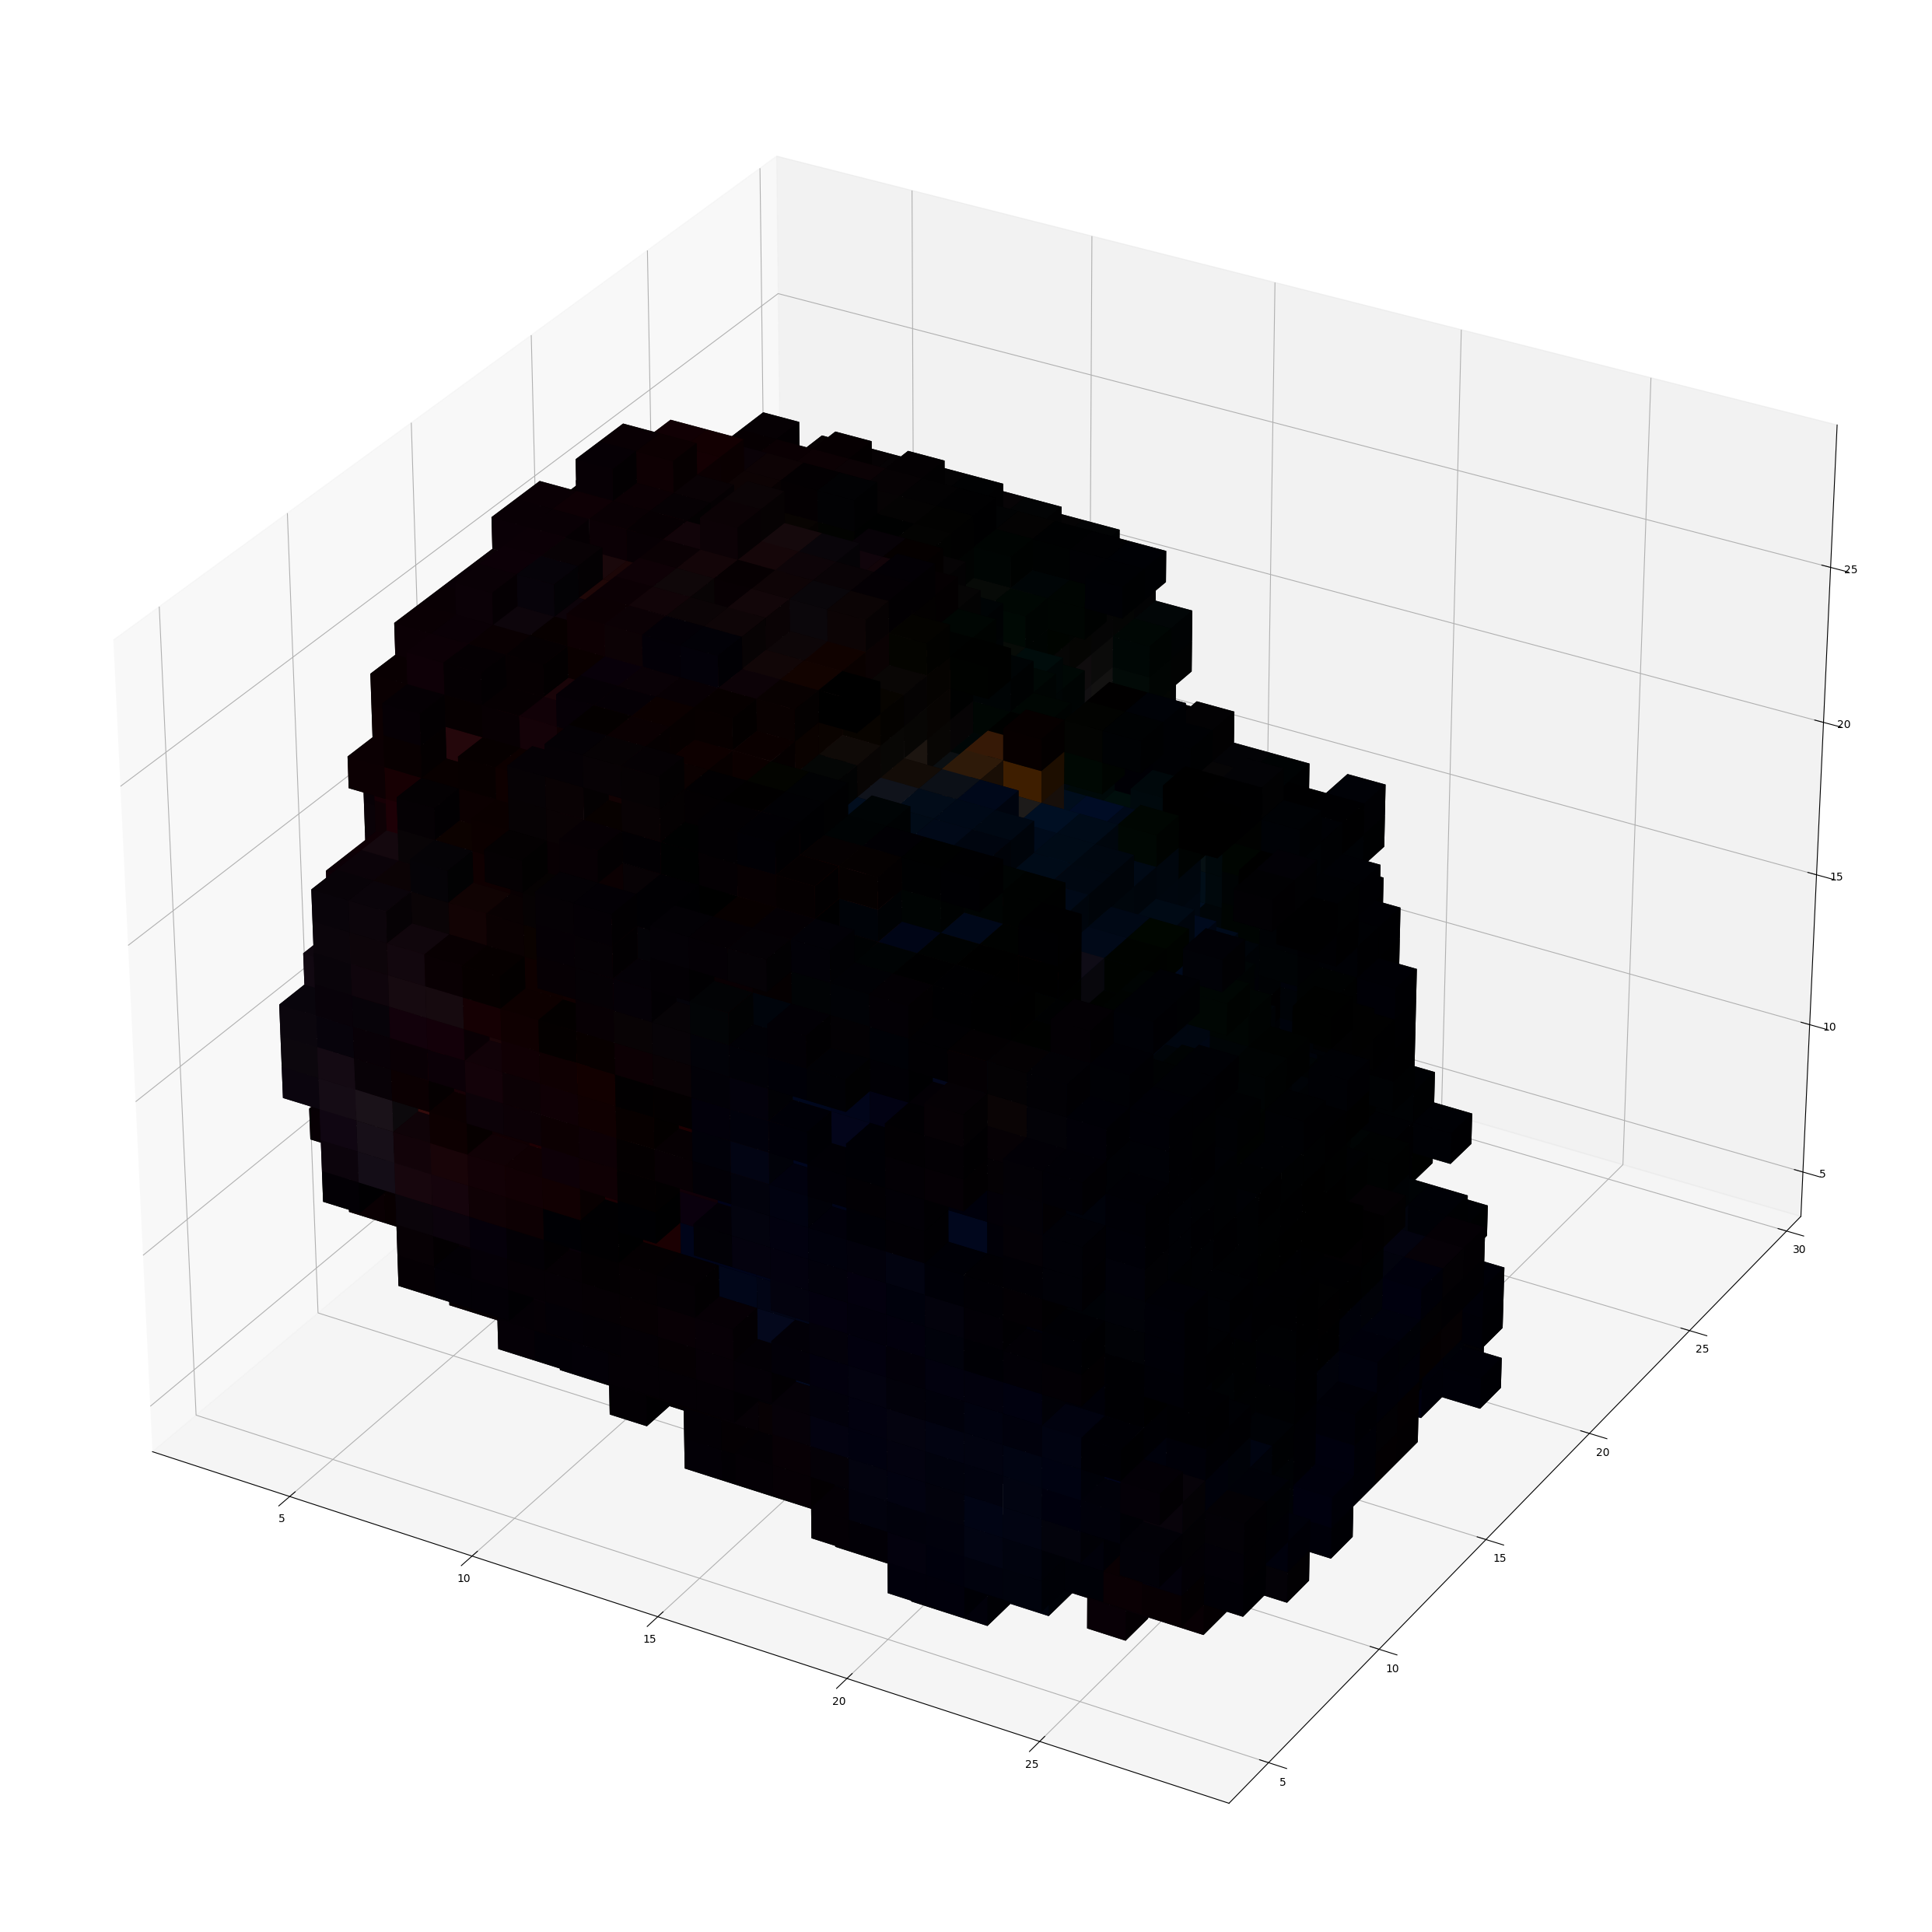

In [ ]:
model.eval()
eval_iter = 32
torch.cuda.empty_cache()
with torch.no_grad():
    x = model.seed.unsqueeze(0)
    for i in tqdm(range(eval_iter)):
        x = model(x)
        # print(f"Iteration {i}: Loss{model.get_loss(x, rgba_voxels)[0].item()}")
    voxel_plot(torch.clamp(x[0, :4], min=0., max=1.))

### Video Generation

In [32]:
# NOTE: ENSURE THE BELOW OUTPUT PATHS ARE CORRECT FOR YOU!

model.eval()
num_imgs = 100
img_dir = "/home/henry/N3CTAR/data/test/imgs"
video_dir = "/home/henry/N3CTAR/data/test"

# img_dir = "/data/grickus/N3CTAR/test/imgs"
# video_dir = "/data/grickus/N3CTAR/test"

with torch.no_grad():
    x = model.seed.unsqueeze(0)
    voxel_plot(torch.clamp(x[0, :4], min=0., max=1.), save_fig=True, img_dir=img_dir, iter=0)
    for i in tqdm(range(num_imgs)):
        x = model(x)
        voxel_plot(torch.clamp(x[0, :4], min=0., max=1.), save_fig=True, img_dir=img_dir, iter=i+1)


  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
file_list = [os.path.join(img_dir, model_name, f"voxel_{i}.png") for i in range(num_imgs+1)]

clip = ImageSequenceClip(file_list, fps=12)
clip.write_videofile(os.path.join(video_dir, f"{model_name}.mp4"))

MoviePy - Building video /home/henry/N3CTAR/data/test/mario_epochs_1000.mp4.
MoviePy - Writing video /home/henry/N3CTAR/data/test/mario_epochs_1000.mp4



MoviePy - Done !
MoviePy - video ready /home/henry/N3CTAR/data/test/mario_epochs_1000.mp4
